# Classify seismic receiver functions using Decision Trees

In this lab exercise, you are going to classify the seismic receiver functions using Decision Trees, and you will implement Decision Trees using Scikit-Learn. Note that you used the same data set for your lab exercise on logistic regression. <br>

More specifically, your task is to classify the P-wave receiver functions, which were computed based on the recorded seismic data, into two categories: good and bad. The entire data set consists of 12,597 receiver functions (i.e., seismic traces), each of which was visually examined and manually labeled as either good or bad by one of Prof. Aibing Li's PhD students, Ying Zhang, in the Department of Earth and Atmospheric Sciences at University of Houston. The good seismic traces are labled (or, encoded)as 1, and bad seismic traces are encoded as 0. <br>

After finishing this exercise, you can expect to <br>
1. be able to implement Decision Trees using Scikit-Learn; <br>
2. have a better understaning of how Decision Trees perform classification;  <br>
3. better understand the regularization role played by the hyperparameter, **max_depth**; <br>
4. be able to diagnose overfitting vs. underfitting by constructing the error curves. <br>

<br>
Author: Jiajia Sun @ University of Houston, 02/21/2019

## 0. Import numpy packages

In [16]:
!pip install numpy h5py matplotlib sklearn graphviz download --user

  Using cached https://files.pythonhosted.org/packages/c2/79/d88026ed8be2da42437023fb30e5401c8e23410a773f37d283c07844e350/download-0.3.3-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6c/4b/c38b5144cf167c4f52288517436ccafefe9dc01b8d1c190e18a6b154cd4a/tqdm-4.31.1-py2.py3-none-any.whl


## 1. Import data
Let us first import our labled data from Traces_qc.mat.

In [17]:
from download import download
url = "https://www.dropbox.com/s/sjqwbmr0bqc93fb/Traces_qc.mat?dl=0"
path = download(url, './downloaded/Traces_qc.mat', replace=True)

Successfully downloaded file to ./downloaded/Traces_qc.mat


In [18]:
import numpy as np
import h5py
with h5py.File("./downloaded/Traces_qc.mat") as f:
    ampdata = [f[element[0]][:] for element in f["Data"]["amps"]]
    flag = [f[element[0]][:] for element in f["Data"]["Flags"]]
    ntr = [f[element[0]][:] for element in f["Data"]["ntr"]]
    time = [f[element[0]][:] for element in f["Data"]["time"]]
    staname = [f[element[0]][:] for element in f["Data"]["staname"]]

In [19]:
ampall = np.zeros((1,651))
flagall = np.zeros(1)
for i in np.arange(201):
    ampall = np.vstack((ampall, ampdata[i]))
    flagall = np.vstack((flagall, flag[i]))
amp_data = np.delete(ampall, 0, 0)
flag_data = np.delete(flagall, 0, 0)

The **amp_data** stores the seismic amplitudes from all seismic stations. The **flag_data** contains the labels for each seismic traces. These labels are encoded as 1s and 0s, with 0 representing bad seismic traces, and 1 corresponding good seismic traces. 

In [20]:
amp_data.shape

(12597, 651)

In [21]:
# total number of bad traces
np.where(flag_data == 0)[0].shape

(9632,)

In [22]:
# total number of good traces
np.nonzero(flag_data)[0].shape

(2965,)

There are 12,597 seismic traces, and each trace contains 651 values. Using machine learning terminology, we have 12,597 data examples (or instances) and each of our data example has 651 features.

## 2. Visualization

Visualiation is a good way to get to know your data better. Let us first take a look at a few seismic traces that were considered as good by our human expert.

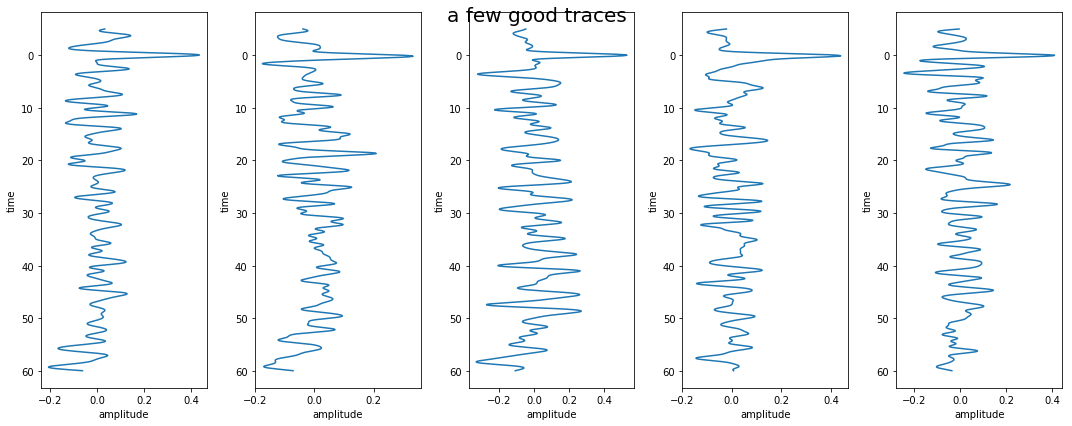

In [7]:
import matplotlib.pyplot as plt

goodtraceindex = np.nonzero(flag_data)[0].reshape(-1,1)

fig, axs = plt.subplots(1,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle('a few good traces', fontsize=20)

axs = axs.ravel()
ic = 0
for icount in goodtraceindex[5:10,0]:       
              
    axs[ic].plot(amp_data[icount,:], time[0])
    axs[ic].invert_yaxis()
    axs[ic].set_xlabel('amplitude')
    axs[ic].set_ylabel('time')
        
    ic = ic + 1
        
# tight_layout() will also adjust spacing between subplots to minimize the overlaps    
plt.tight_layout()      
plt.show()       

Let us also take a look at those 'bad' seismic traces. In practice, these bad seismic traces will be discarded, and excluded from any further analysis.

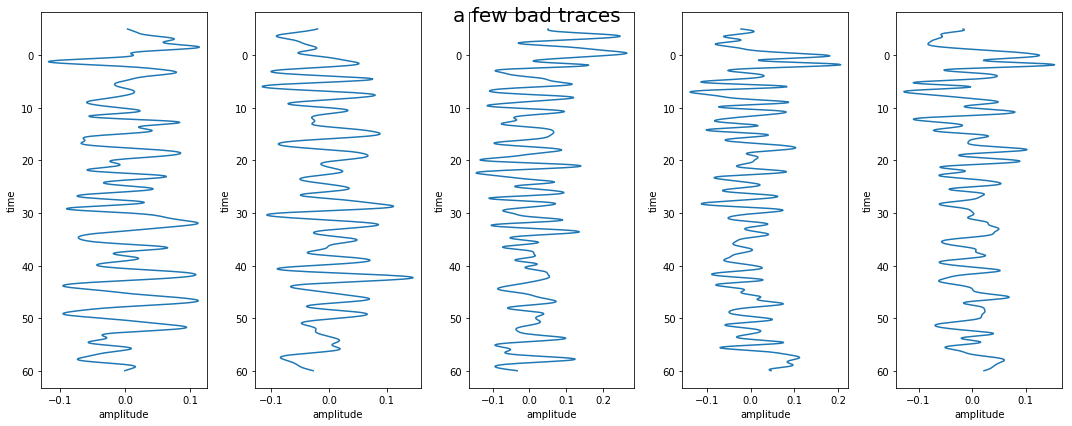

In [8]:
badtraceindex = np.where(flag_data == 0)[0].reshape(-1,1)

fig, axs = plt.subplots(1,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle('a few bad traces', fontsize=20)

axs = axs.ravel()
ic = 0
for icount in badtraceindex[10:15,0]:       
              
    axs[ic].plot(amp_data[icount,:], time[0])
    axs[ic].invert_yaxis()
    axs[ic].set_xlabel('amplitude')
    axs[ic].set_ylabel('time')
        
    ic = ic + 1
        
# tight_layout() will also adjust spacing between subplots to minimize the overlaps    
plt.tight_layout()      
plt.show()       

The 'good' seismic traces have several characteristic features. First, We expect to see a clearly defined peak at time 0, which corresponds to when the incident P wave converted to S wave. We also expect to see a second peak around 4 or 5 seconds, which corresponds to the Ps conversions from Moho. The amplitude for the peak at time 0 should be clearly higher than that for the second peak.

## 3. Preprocessing data
For most ML application, We will perform the standard preprocessing by removing the mean and scaling to unit variance, just as what you did for your lab exercises on Logistic Regression and Support Vector Machines. The reason for it is that different features in our data might be vastly different scales. This will cause a lot of problems for minimization. The standardization (or scaling) helps alleviate this problem. In fact, it helps speed up the convergence of gradient descent and shorten the training time. It also helps improve SVM results. See more at [this Wikipedia page](https://en.wikipedia.org/wiki/Feature_scaling), [this Stackexchange webage](https://stats.stackexchange.com/questions/41704/how-and-why-do-normalization-and-feature-scaling-work) and the [official Scikit-Learn webpage on standardization](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html). <br>

However, for Decision Trees (and also the Random Forests that build upon Decisiont Trees), at each node, we simply ask a question about one single feature, and then split the data sets at the threshold value. It turns out that, features at different scales do not affect the splitting and thefore, the growing of a decision tree. Therefore, the standardization procedure is usually skipped for Decision Trees.

But we still need to randomly permute our data, just as what you did in your lab exercise on logistic regression. The reason for doing this is to avoid the situation where your training data are ordered in some specific way. For example, suppose we have 10,000 seismic traces, and somebody put all the 8,000 good seismic traces together, followed by all the 2,000 bad traces. Also suppose that we decide to split our data into training and test sets with the proportion of 4:1. If we do not randomly permute our training data set, then our training data will be all the good seismic traces, and our validation or test data set will be all the bad ones. This is very dangerous because your machine lerning algorithm will not have any chance of learning from the bad seismic traces at the training stage, and you can expect that no matter how you train a machine learning model, it will not predict well on the validation/test data. It is like a child is exposed to only cat images, but you ask him or her to tell if an image contains a car. Randomly permuting the data will ensure that the training set contains data from every category (good and bad), and validation/test set also contains data from all categories. 

In [9]:
np.random.seed(42)
whole_data = np.append(amp_data,flag_data,1) # put all the seismic traces and their lables into one matrix which contain the whole data set for subsequent machine learing.

<font color = red>**Task 1:**</font> Randomly permute the data stored in the variable <font color=blue>**whole_data**</font> using <font color=blue>*np.random.permutation*</font>, and store the permuted data in a new variable <font color=blue>**whole_data_permute**</font>. <font color = red>**(5 points)**</font> <br>
<br>
**HINT**: If you forget how to do it, please refer back to your lab exercise on logistic regression. Please note that in your lab exercise on logistic regression, you used <font color=blue>**training_data_permute**</font> as the name of the variable storing the permuted data, but here you are supposed to use <font color=blue>**whole_data_permute**</font> as the variable name.

In [ ]:
# Answer to Task 1


## 4. Split data into training and cross-validation sets

We are going to use the first 10,000 seismic traces as out training data set, and the rest 2,597 traces as validation dat set.

<font color = red>**Task 2:**</font> Create the training data set by assigning the first <font color=red>**10,000**</font> data examples and their corresponding labels in <font color=blue>**whole_data_permute**</font> to new variables, <font color=green>**X_train**</font> and <font color=green>**y_train**</font>. <font color = red>**(5 points)**</font> <br>
<br>
**HINT**: If you forget how to do it, please refer back to your lab exercise on logistic regression.

In [ ]:
# Ansewr to Task 2


<font color = red>**Task 3:**</font> Create the validation data set by assigning the remaining data examples and their corresponding labels in <font color=blue>**whole_data_permute**</font> to new variables, <font color=green>**X_validation**</font> and <font color=green>**y_validation**</font>. <font color = red>**(5 points)**</font> <br>
<br>
**HINT**: If you forget how to do it, please refer back to your lab exercise on logistic regression.

In [ ]:
# Answer to Task 3


## 5. Set up Decision Tree classifier

<font color = red>**Task 4:**</font> Import *DecisionTreeClassifier* from Scikit-Learn. <font color = red>**(5 points)**</font> <br>
<br>
**HINT**: If you forget how to do it, please refer back to our lecture slides, or the accompanying example notebook *DecisionTrees_example.ipynb*.

In [ ]:
# Answer to Task 4


<font color = red>**Task 5:**</font> Set up your DecisionTreeClassifier by setting <font color=blue>*max_depth = 2*</font>, and <font color=blue>*random_state = 42*</font>, and assign this classifier to a new variable <font color=red>**tree_clf_2**</font> (DO NOT forget the last digit 2 in the variable name) <font color = red>**(5 points)**</font> <br>
<br>
**HINT**: If you forget how to do it, please refer back to our lecture slides, or the accompanying example notebook *DecisionTrees_example.ipynb*.

In [ ]:
# Answer to Task 5


## 6. Train a decision tree

<font color = red>**Task 6:**</font> Train a decision tree using the **training** data set, <font color=blue>**X_train**</font> and <font color=blue>**y_train**</font>, and the classifier, <font color=blue>**tree_clf_2**</font>, you set up above. <font color = red>**(5 points)**</font> <br>
<br>
**HINT**: If you forget how to do it, please refer back to our lecture slides, or the accompanying example notebook *DecisionTrees_example.ipynb*.

In [ ]:
# Answer to Task 6


## 7. Evaluation

After we have successfully trained a decision tree, we need to evalute it and determine if it is a good or bad one. This is also what happens for any practical ML project. That is, after you get your first-pass results (i.e., obtain your first ML model through learning), you ought to evaluate it in order to determine what to do next. Usually, the first-pass results are far from being satisfactory due to either under-fitting or over-fitting. Evaluation is important before it informs you what problem you run into and provides clues for improvements.

<font color = red>**Task 7:**</font> Make predictions on the validation data set, and assign the predictions to a new variable, <font color=blue>**y_pred**</font>. <font color = red>**(10 points)**</font> <br>
<br>
**HINT**: Suppose the name of your classifier is *my_tree_classifier*, and the name of your cross-validation data (excluding the labels) is *my_validation*, then you can make prediction by the following line of code: <br>
<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *my_tree_classifier.predict(my_validation)* <br>
<br>
Do not forget to assign the predictions to a new variable <font color=blue>**y_pred**</font>.

In [ ]:
# Answer to Task 7


Now, let us calcuate the precision and recall values by comparing our predictions, *y_pred*, with the true labels, *y_validation*. We are going to use the *classification_report* from Scikit-Learn for this purpose. <br>
<br>
To learn more about classification_report and see examples, please refer to this [Scikit-Learn webpage](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_validation, y_pred, target_names=['bad','good']))

Your classification results should look very similar (ideally, identical) to the following: <br>
<img src = "classification_report.PNG">

<font color = red>**Task 8:**</font> Please explain what the precision value, 0.92, and recall value, 0.79, mean, for the cateogry of 'bad' seismic traces. Similarly, explain what the precision value, 0.52, and recall value, 0.76, mean, for the cateogry of 'good' seismic traces.  <font color = red>**(10 points)**</font> <br>
<br>
**HINT**: Please refer to your last lab exericse on SVM for a better understanding of what precision and recall means. <br>
<br>

(answer to Task 8:)


Let us calculate the **error** of the predictions on the training data.

In [ ]:
1- tree_clf_2.score(X_train, y_train) # Recall that you used .score in your lab exercise on logistic regression.

The expeted output is:  &nbsp;&nbsp;&nbsp;&nbsp; 0.21760000000000002

Let us also calculate the **error** of the predictions on the validation data set.

In [ ]:
1 - tree_clf_2.score(X_validation,y_validation)

The expeted output is:  &nbsp;&nbsp;&nbsp;&nbsp; 0.21948402002310363

Now, let us calculate the importance of all the features, and take a look at the top 10 most important features. These are the features that Decision Trees used when deciding how to split the data set and growing the tree.

In [ ]:
# The following code is based on a modification of the codes in this webpage
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
importances = tree_clf_2.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(10):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(10), importances[indices][:10])
plt.xticks(range(10), indices)
plt.xlim([-1, 10])
plt.show()

You can also export the actual decision tree that was trained.

In [ ]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree_clf_2, out_file=None, 
                         feature_names=None,  
                         class_names=['bad','good'],  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

Your decision tree should look like the following tree: <br>
<img src = "tree.png">

To learn more about how to explore a decision tree in Scikit-Learn, please visit [this webpage](https://stackoverflow.com/questions/32506951/how-to-explore-a-decision-tree-built-using-scikit-learn)

<font color = red>**Task 9:**</font> Explain what each number means in the root node (i.e., the node at the very top).  <font color = red>**(10 points)**</font> <br>
<br>
**HINT**: Please refer to our lecture slides for what each number represents. <br>

In [ ]:
(answer to Task 9:)


## 8. Construct error curves

Looking at the above training and cross-validation errors, it is not straightforward to tell whether we had an overfitting or underfitting problem (or if we have already had the best possible classifier). In order to diagose our problem, it is helpful to construct the error curves such as the one shown below. Please refer to our lecture slides **Week3_Concept.pdf**, if you need to refresh your memory of the error curves. <br>

<img src = "errorcurve.png">



The decision tree that you trained above is based on <font color=blue>*max_depth* = 2</font>. Remember that this hyperparameter, <font color=red>**max_depth**</font>, plays the role of regularization. The larger this value is, the deeper the tree will be, and the more capable the decision tree will be of fitting our training data. If we set <font color=blue>*max_depth*</font> to unlimited, then the tree will grow unlimitedly in order to perfectly fit our training data (i.e., overfitting). <br>

Now, let us construct the error curves by increasing <font color=blue>*max_depth*</font> from 3 to 12 while keeping everyelse the same as the previous tree.

In [ ]:
train_errors = np.zeros(11)
validation_errors = np.zeros(11)

train_errors[0] = 0.218
validation_errors[0] = 0.219

<font color = red>**Task 10:**</font> Train **10** decision trees by assuming <font color=blue>**max_depth**</font> = 3, 4, 5, 6, 7, 8, 9, 10, 11, and 12. Name each one of your decision trees as <font color=blue>*tree_clf_number*</font> where <font color=red>*number*</font> is the value of the <font color=blue>*max_depth*</font> for that tree. For example, if <font color=blue>*max_depth*</font> = 3, then you should name your decision tree as <font color=blue>*tree_clf_3*</font>.  <br>
<br>
Calculate the prediction errors on both training and validation data sets for each decision tree. And store them in the variables, <font color=red>*train_errors*</font>, and <font color=red>*validation_errors*</font>, that I have already created for you in the above cell.  <font color = red>**(30 points)**</font> <br>
<br>
**HINT**: You did something very similar in your lab exercise on logistic regression (by increasing the size of the training data). <br>

In [ ]:
# Answer to Task 10


Now, let us plot up the error curves.

In [ ]:
import matplotlib.pyplot as plt
max_depth =  np.arange(2,13)
plt.plot(max_depth,train_errors,'-ro',label="training errors")
plt.plot(max_depth,validation_errors,'-bo',label="validation errors")
plt.title('error curves',fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.xlabel("Max_depth", fontsize=20)
plt.ylabel("Prediction errors", fontsize=20, rotation=90)
plt.show()

Your error curves should look very similar (ideally, identical) to those in the following picture. <br>

<img src = "errorcurve_realdata.png">

Great! We see roughly the same trend in the above error curves, which were constructed using real seismic data, as what we saw in the theoretical error curves. 

In [ ]:
min(validation_errors)

<font color = red>**BONUS:**</font> Explain the behavior of the error curves. Also, please write down what else you can learn from the error curves. <font color = red>**(10 points)**</font> <br>
<br>
**HINT**: For example, when <font color=blue>*max_depth*</font> = 2, without the above error curves, if we only look at the training and validation errors, 0.218 and 0.219, it is not straightforward to tell if we overfit or underfit the data. But with the help of the error curves, we now can confidently say that we underfit our data (that is, some of the important features in our data were not captured by the decision tree) when *max_depth* = 2.  <br>

In [ ]:
(answer to Bonus:)


## 9. Applications of Decision Trees to geoscience 

<font color = red>**Task 11:**</font> Do a literature search and look for at least one example where Decision Tree is used to solve some geoscience-related problems. Then, report the source of the information (e.g., URL, DOI, etc.), and summarize the example using a few sentences. <font color = red> **(10 points)**</font>

(answer to Task 11:)


## 10. Acknowledgments
I would like to thank Ying Zhang for manually labeling all the seismic traces, and Prof. Aibing Li for making this data set available to the students in this class. Ms. Zhang also kindly explained the fundamentals of seismic P-wave receiver functions to me. <br>

<img src = "photo.png" width="400">

## 11. Useful links
In addition to the links I provided above, you might find the materials in the following webpages useful.
1. [Feature importances](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
2. [Plot bar chart](https://pythonspot.com/matplotlib-bar-chart/)
3. [DecisionTreeClassifier on Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#)